In [5]:
pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.io.sql as sqlio
import psycopg2 as ps
import warnings

# Tüm uyarıları gizle
warnings.filterwarnings("ignore")

In [7]:
conn = ps.connect(dbname="Northwind",
                  user="postgres",
                  password="12345",
                  port = "5432")

# CASE 1: REGION ANALYSIS

The sales team wants to see the distribution of total net revenue by region. In addition to revenue, we also need to consider the average shipping costs of the regions. After the region-based analysis, the same analysis is requested to be done on a country basis.

In [47]:
sql1 = """select
	region_description,
	count(distinct o.order_id) as total_orders,
	round(sum(od.quantity)) as total_quantity_sold,
	round(sum(od.unit_price * od.quantity * (1 - od.discount))) AS total_net_revenue,
	round(avg(shipped_date - order_date)) as avg_delivery_day,
	round(avg(freight)) as avg_shipping_cost
from orders o
join order_details od ON o.order_id = od.order_id
join employees e ON o.employee_id = e.employee_id
join employeeterritories et ON e.employee_id = et.employee_id
join territories t ON et.territory_id = t.territory_id
join region r ON t.region_id = r.region_id
group by 1
order by 4 desc"""

In [49]:
df1 = sqlio.read_sql_query(sql1,conn)
df1

,region_description,total_orders,total_quantity_sold,total_net_revenue,avg_delivery_day,avg_shipping_cost
0,Eastern,417,108655.0,2730198.0,8.0,100.0
1,Western,139,64175.0,1615248.0,8.0,105.0
2,Northern,147,42342.0,1048606.0,9.0,92.0
3,Southern,127,31408.0,811251.0,9.0,111.0


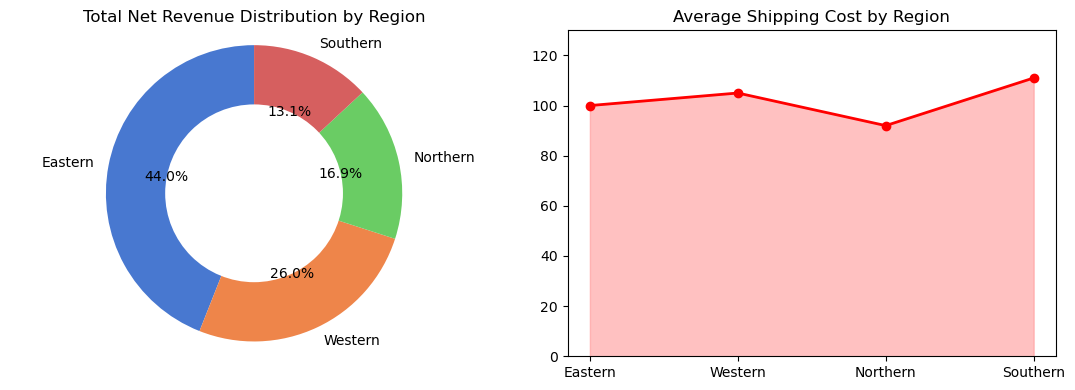

In [111]:
regions = df1['region_description']
total_net_revenue = df1['total_net_revenue']
avg_shipping_cost = df1['avg_shipping_cost']

colors = sns.color_palette('muted', len(regions))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# Donut chart (total_net_revenue distribution)
ax1.pie(total_net_revenue, labels=regions, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 10})
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
ax1.add_artist(centre_circle)
ax1.set_title('Total Net Revenue Distribution by Region', fontsize=12)
ax1.axis('equal')

# Area chart (avg_shipping_cost)
ax2.fill_between(regions, avg_shipping_cost, color='#ff9999', alpha=0.6)
ax2.plot(regions, avg_shipping_cost, color='red', marker='o', linewidth=2)
ax2.set_title('Average Shipping Cost by Region', fontsize=12)
ax2.set_ylim(0, 130)

plt.tight_layout()
plt.show()


In [51]:
sql2 = """select
	ship_country,
	count(distinct o.order_id) as total_orders,
	round(sum(od.quantity)) as total_quantity_sold,
	round(sum(od.unit_price * od.quantity * (1 - od.discount))) AS total_net_revenue,
	round(avg(shipped_date - order_date)) as avg_delivery_day,
	round(avg(freight)) as avg_shipping_cost
from orders o
join order_details od ON o.order_id = od.order_id
join employees e ON o.employee_id = e.employee_id
join employeeterritories et ON e.employee_id = et.employee_id
join territories t ON et.territory_id = t.territory_id
join region r ON t.region_id = r.region_id
group by 1
order by 4 desc"""

In [52]:
df2 = sqlio.read_sql_query(sql2,conn)
df2.head(10)

,ship_country,total_orders,total_quantity_sold,total_net_revenue,avg_delivery_day,avg_shipping_cost
0,USA,122,43892.0,1172704.0,9.0,158.0
1,Germany,122,41066.0,1121333.0,9.0,121.0
2,Austria,40,26625.0,697794.0,7.0,226.0
3,Brazil,83,20819.0,474605.0,8.0,83.0
4,France,77,14373.0,347243.0,8.0,61.0
5,UK,56,13239.0,288636.0,8.0,65.0
6,Sweden,37,11374.0,286938.0,10.0,98.0
7,Venezuela,46,13485.0,270713.0,8.0,74.0
8,Ireland,19,9124.0,270692.0,11.0,132.0
9,Canada,30,9198.0,270090.0,6.0,83.0


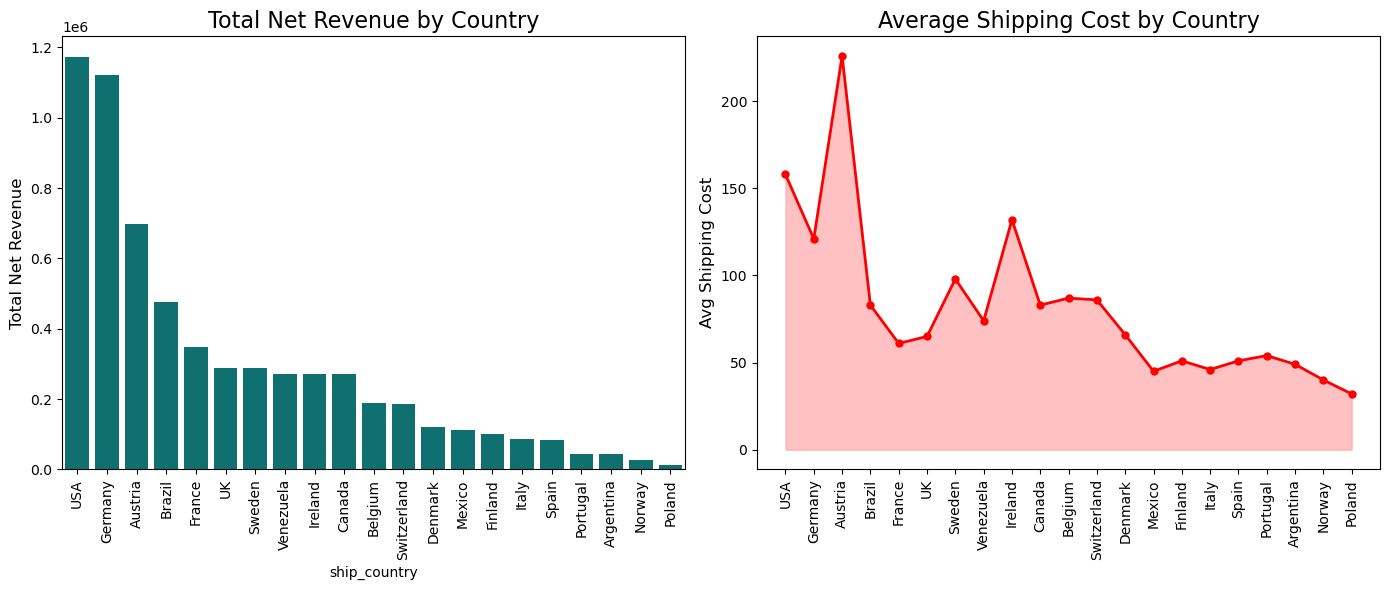

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# First axis: Bar chart (total_net_revenue)
sns.barplot(x='ship_country', y='total_net_revenue', data=df2, color='teal', ax=ax1)
ax1.set_title('Total Net Revenue by Country', fontsize=16)
ax1.set_ylabel('Total Net Revenue', fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# Second axis: Area chart (avg_shipping_cost)
ax2.fill_between(df2['ship_country'], df2['avg_shipping_cost'], color='#ff9999', alpha=0.6)
ax2.plot(df2['ship_country'], df2['avg_shipping_cost'], marker='o', color='red', linestyle='-', linewidth=2, markersize=5)
ax2.set_title('Average Shipping Cost by Country', fontsize=16)
ax2.set_ylabel('Avg Shipping Cost', fontsize=12)
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


# CASE 2: SUPPLIER ANALYSIS

In this analysis, we want to see the distribution of total orders and total net revenue on a supplier basis. We will see which suppliers sold the most products and how much net income was generated from these products.

In [3]:
sql3 = """SELECT 
	s.company_name as supplier_name,
	s.country,
	COUNT(o.order_id) AS total_orders,
	ROUND(SUM(od.quantity * od.unit_price)) AS total_sales_amount,
	ROUND(SUM(od.quantity * od.unit_price * (1 - od.discount))) AS total_net_revenue
FROM suppliers s
JOIN 
	products p ON s.supplier_id = p.supplier_id
JOIN 
	order_details od ON p.product_id = od.product_id
JOIN
	orders o ON od.order_id = o.order_id
GROUP BY 
	s.company_name, s.country
ORDER BY 
	total_orders DESC"""

In [12]:
df3 = sqlio.read_sql_query(sql3,conn)
df3.head(10)

,supplier_name,country,total_orders,total_sales_amount,total_net_revenue
0,Plutzer Lebensmittelgroßmärkte AG,Germany,179,155947.0,145372.0
1,"Specialty Biscuits, Ltd.",UK,164,63071.0,59032.0
2,"Pavlova, Ltd.",Australia,163,115386.0,106460.0
3,Norske Meierier,Norway,105,46897.0,43142.0
4,Gai pâturage,France,105,126582.0,117981.0
5,Formaggi Fortini s.r.l.,Italy,104,51082.0,48225.0
6,"G'day, Mate",Australia,98,69637.0,65627.0
7,New England Seafood Cannery,USA,88,28146.0,26591.0
8,Leka Trading,Singapore,82,44936.0,42018.0
9,Pasta Buttini s.r.l.,Italy,73,52929.0,50255.0


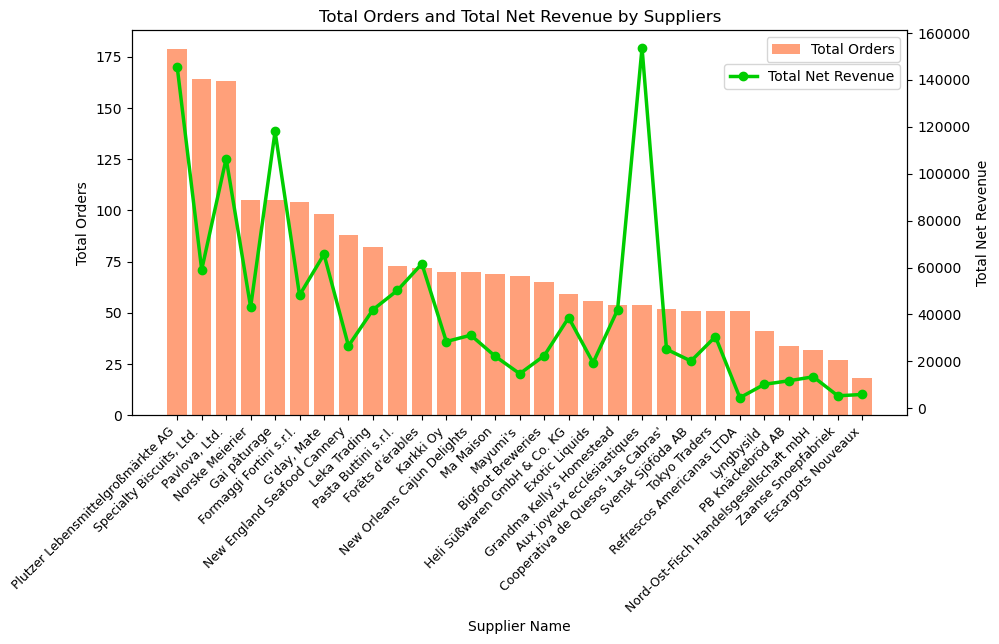

In [121]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar chart (total_orders)
bars = ax1.bar(df3['supplier_name'], df3['total_orders'], color='#ffa07a', label='Total Orders')
ax1.set_xlabel('Supplier Name')
ax1.set_ylabel('Total Orders')
ax1.tick_params(axis='y')
ax1.set_xticklabels(df3['supplier_name'], rotation=45, ha='right', size=9)

# Create the second axis
ax2 = ax1.twinx()

# Line chart (total_net_revenue)
line = ax2.plot(df3['supplier_name'], df3['total_net_revenue'], color='#00cd00', marker='o', linewidth=2.5, label='Total Net Revenue')
ax2.set_ylabel('Total Net Revenue')
ax2.tick_params(axis='y')

# Add Legend
ax1.legend(loc='upper right')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.93))

plt.title('Total Orders and Total Net Revenue by Suppliers')
plt.show()


### SUPPLIER = "Aux joyeux ecclésiastiques" REVIEW

In [63]:
sql4 = """SELECT
	distinct product_name,
	COUNT(o.order_id) total_orders,
	ROUND(AVG(od.unit_price)) avg_unit_price
FROM suppliers s
JOIN 
	products p ON s.supplier_id = p.supplier_id
JOIN 
	order_details od ON p.product_id = od.product_id
JOIN
	orders o ON od.order_id = o.order_id
WHERE company_name = 'Aux joyeux ecclésiastiques'
GROUP BY 1
ORDER BY 2"""

In [64]:
df4 = sqlio.read_sql_query(sql4,conn)
df4.head(10)

,product_name,total_orders,avg_unit_price
0,Côte de Blaye,24,246.0
1,Chartreuse verte,30,17.0


### AVERAGE UNIT PRICES

In [65]:
sql5 = """SELECT
	company_name,
    country,
	product_name,
	ROUND(AVG(od.unit_price)) avg_unit_price
FROM suppliers s
JOIN 
	products p ON s.supplier_id = p.supplier_id
JOIN 
	order_details od ON p.product_id = od.product_id
JOIN
	orders o ON od.order_id = o.order_id
GROUP BY 1,2,3
ORDER BY 2"""

In [66]:
df5 = sqlio.read_sql_query(sql5,conn)
df5

,company_name,country,product_name,avg_unit_price
0,"G'day, Mate",Australia,Filo Mix,7.0
1,"G'day, Mate",Australia,Manjimup Dried Apples,51.0
2,"G'day, Mate",Australia,Perth Pasties,30.0
3,"Pavlova, Ltd.",Australia,Alice Mutton,36.0
4,"Pavlova, Ltd.",Australia,Carnarvon Tigers,60.0
...,...,...,...,...
72,New England Seafood Cannery,USA,Jack's New England Clam Chowder,9.0
73,New Orleans Cajun Delights,USA,Chef Anton's Cajun Seasoning,21.0
74,New Orleans Cajun Delights,USA,Chef Anton's Gumbo Mix,20.0
75,New Orleans Cajun Delights,USA,Louisiana Fiery Hot Pepper Sauce,19.0


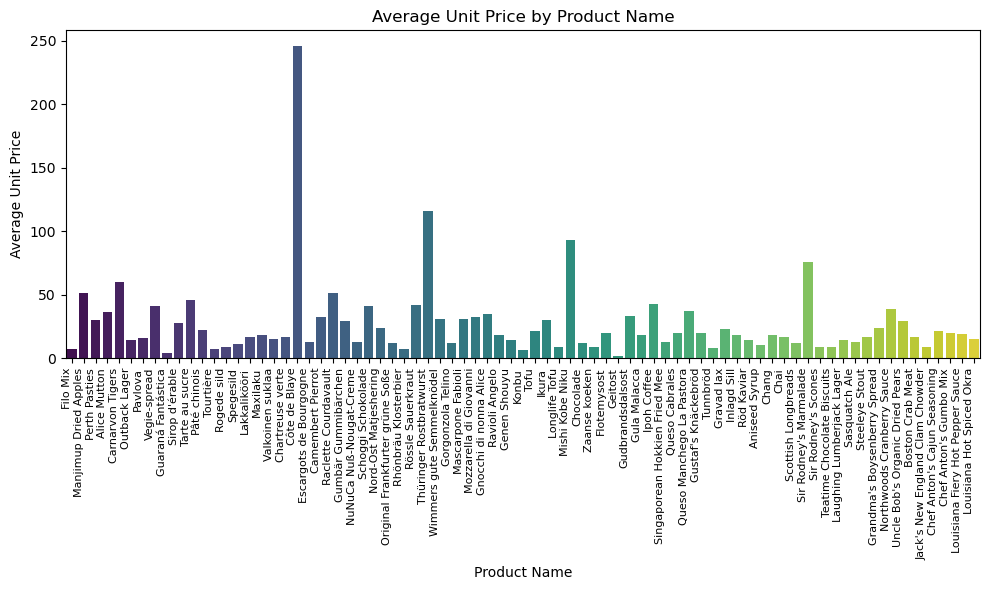

In [123]:
plt.figure(figsize=(10, 6))

# Bar chart (avg_unşt_price)
sns.barplot(data=df5, x='product_name', y='avg_unit_price', palette='viridis')

# Set axes and title
plt.xlabel('Product Name')
plt.ylabel('Average Unit Price')
plt.title('Average Unit Price by Product Name')
plt.xticks(rotation=90, ha='right', size=8) 

plt.tight_layout()
plt.show()


# CASE 3: EMPLOYEE ANALYSIS

The HR team asked us for an analysis to see employee performance. We will evaluate employees based on their total net sales. Then we will take the analysis a step further and examine the 3 employees with the highest sales in each category by product category.

### EMPLOYEE ANALYSIS BY TOTAL NET SALES

In [71]:
sql6 = """SELECT
	e.employee_id,
    CONCAT(e.first_name, ' ', e.last_name) AS employee_name,
    COUNT(o.order_id) AS total_orders,
    ROUND(SUM(od.quantity * od.unit_price * (1 - od.discount))) AS total_net_sales_amount
FROM employees e
JOIN 
	orders o ON e.employee_id = o.employee_id
JOIN 
	order_details od ON o.order_id = od.order_id
GROUP BY 
	e.employee_id, employee_name
ORDER BY 4 DESC;"""

In [72]:
df6 = sqlio.read_sql_query(sql6,conn)
df6.head(10)

,employee_id,employee_name,total_orders,total_net_sales_amount
0,4,Margaret Peacock,420,232891.0
1,3,Janet Leverling,321,202813.0
2,1,Nancy Davolio,345,192108.0
3,2,Andrew Fuller,241,166538.0
4,8,Laura Callahan,260,126862.0
5,7,Robert King,176,124568.0
6,9,Anne Dodsworth,107,77308.0
7,6,Michael Suyama,168,73913.0
8,5,Steven Buchanan,117,68792.0


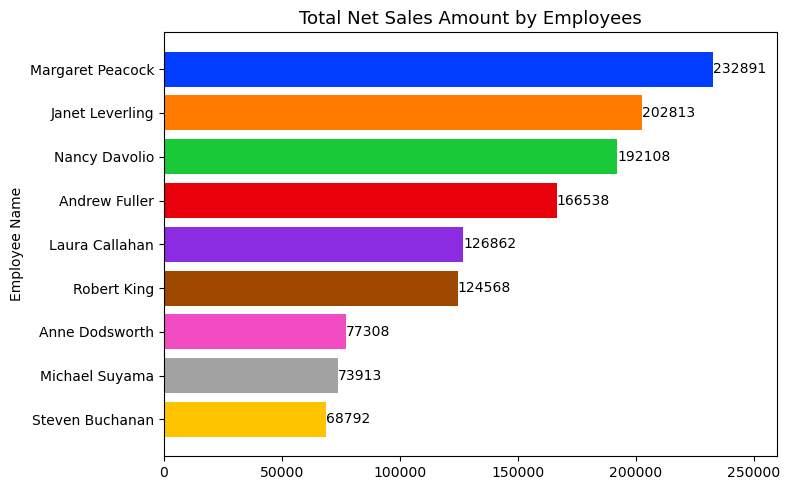

In [192]:
# Color palette
colors = sns.color_palette('bright', len(df6['employee_name']))

# Adjust the size of the chart
fig, ax = plt.subplots(figsize=(8, 5))

# Horizontal bar chart
bars = ax.barh(df6['employee_name'], df6['total_net_sales_amount'], color=colors)
ax.set_ylabel('Employee Name')
ax.set_title('Total Net Sales Amount by Employees', size=13)
ax.set_xlim(0, 260000)

# Show data labels
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}', 
            va='center', ha='left')

# Invert the Y axis
ax.invert_yaxis()

plt.tight_layout()
plt.show()


### EMPLOYEE REVIEW BY PRODUCT CATEGORIES

In [77]:
sql7 = """SELECT
	category_name,
    CONCAT(e.first_name, ' ', e.last_name) AS employee_name,
    COUNT(o.order_id) AS total_orders,
    ROUND(SUM(od.quantity * od.unit_price * (1 - od.discount))) AS total_net_sales_amount,
    ROUND(SUM(od.quantity * od.discount)) AS total_discount
FROM employees e
JOIN 
	orders o ON e.employee_id = o.employee_id
JOIN 
	order_details od ON o.order_id = od.order_id
JOIN 
	products p ON od.product_id = p.product_id
JOIN 
	categories c ON p.category_id = c.category_id
GROUP BY 
	employee_name, category_name
ORDER BY 4 DESC"""

In [78]:
df7 = sqlio.read_sql_query(sql7,conn)
df7.head(10)

,category_name,employee_name,total_orders,total_net_sales_amount,total_discount
0,Beverages,Margaret Peacock,75,50308.0,113.0
1,Beverages,Nancy Davolio,60,46599.0,128.0
2,Beverages,Janet Leverling,63,44757.0,88.0
3,Beverages,Andrew Fuller,45,40248.0,65.0
4,Dairy Products,Nancy Davolio,65,36023.0,86.0
5,Confections,Janet Leverling,52,33622.0,54.0
6,Dairy Products,Margaret Peacock,54,33550.0,127.0
7,Dairy Products,Janet Leverling,51,32321.0,74.0
8,Meat/Poultry,Margaret Peacock,35,30867.0,98.0
9,Meat/Poultry,Andrew Fuller,26,29874.0,57.0


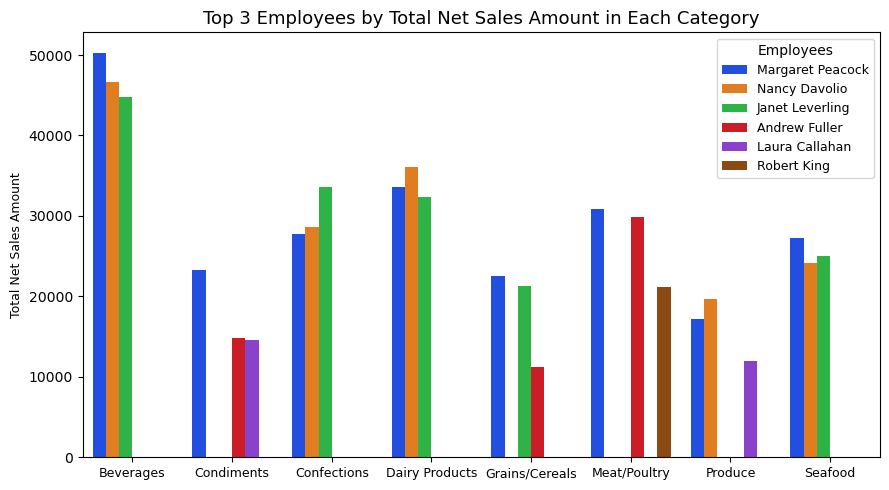

In [126]:
# Select employee names, category names and total net sales amounts
sales_data = df7.groupby(['employee_name', 'category_name'])['total_net_sales_amount'].sum().reset_index()

# Select the top 3 employees for each category
top_employees = sales_data.sort_values(['category_name', 'total_net_sales_amount'], ascending=[True, False])\
                           .groupby('category_name')\
                           .head(3)

# Create multiple bar chart using categories and employees
plt.figure(figsize=(9, 5))

# Bar chart
sns.barplot(data=top_employees, x='category_name', y='total_net_sales_amount', hue='employee_name', palette='bright')

# Set title and labels
plt.title('Top 3 Employees by Total Net Sales Amount in Each Category', fontsize=13)
plt.xlabel('')
plt.ylabel('Total Net Sales Amount', fontsize=9)
plt.xticks(size=9)

plt.tight_layout()
plt.legend(title='Employees', fontsize=9)
plt.show()


# CASE 4: CUSTOMER ANALYSIS

The marketing team asked us for a customer analysis on which customers they should target. We will analyze customers based on the total number of orders.

In [81]:
sql8 = """SELECT 
	c.customer_id,
	c.company_name,
	c.country,
	SUM(od.quantity) AS total_quantity_sold,
	COUNT(distinct o.order_id) AS total_orders,
	ROUND(SUM(od.quantity * od.unit_price * (1 - od.discount))) AS total_order_value
FROM customers c
JOIN 
	orders o ON c.customer_id = o.customer_id
JOIN
	order_details od ON o.order_id = od.order_id
JOIN products as p
		on od.product_id = p.product_id
WHERE p.discontinued=0	
GROUP BY 1,2,3
ORDER BY 
	total_order_value DESC
LIMIT 10"""

In [82]:
df8 = sqlio.read_sql_query(sql8,conn)
df8

,customer_id,company_name,country,total_quantity_sold,total_orders,total_order_value
0,QUICK,QUICK-Stop,Germany,3462,27,97399.0
1,ERNSH,Ernst Handel,Austria,3835,30,89522.0
2,SAVEA,Save-a-lot Markets,USA,3963,31,72514.0
3,RATTC,Rattlesnake Canyon Grocery,USA,1183,18,46885.0
4,HANAR,Hanari Carnes,Brazil,754,13,31957.0
5,HUNGO,Hungry Owl All-Night Grocers,Ireland,1377,19,27868.0
6,KOENE,Königlich Essen,Germany,849,14,27816.0
7,MEREP,Mère Paillarde,Canada,841,13,26247.0
8,FRANK,Frankenversand,Germany,1434,15,24242.0
9,FOLKO,Folk och fä HB,Sweden,1119,19,23994.0


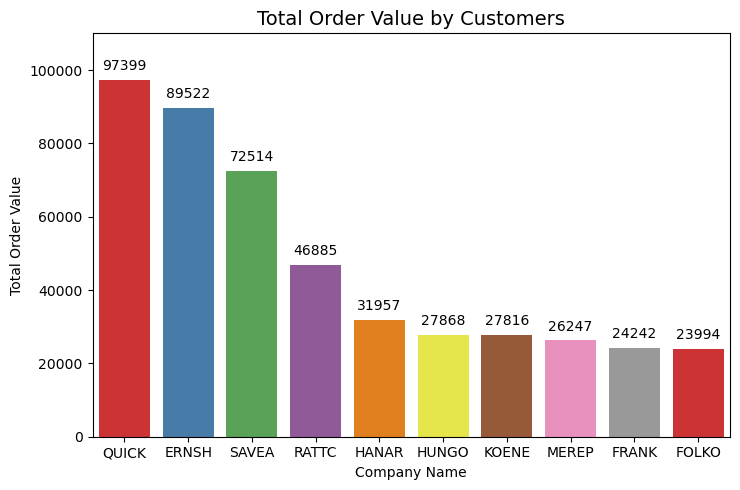

In [193]:
plt.figure(figsize=(7.5,5))

# Barplot
ax = sns.barplot(data=df8, x='customer_id', y='total_order_value', palette='Set1')
ax.set_ylim(0, 110000)

plt.title('Total Order Value by Customers', fontsize=14)
plt.xlabel('Company Name', fontsize=10)
plt.ylabel('Total Order Value', fontsize=10)
plt.xticks(size=10)

# Adding data labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', 
                xytext = (0, 5),
                textcoords = 'offset points')

# Show the graph
plt.tight_layout()
plt.show()


### CUSTOMER REVIEW BY PRODUCT CATEGORIES

In [209]:
sql11 = """WITH customer_cat_sales AS (
    SELECT
        o.customer_id,
        cat.category_name,
        SUM(od.quantity) AS total_quantity_sold,
        ROW_NUMBER() OVER (PARTITION BY cat.category_name ORDER BY SUM(od.quantity) DESC) AS rn
    FROM orders o
    JOIN order_details od ON o.order_id = od.order_id
    JOIN products p ON od.product_id = p.product_id
    JOIN categories cat ON p.category_id = cat.category_id
    WHERE p.discontinued = 0
    GROUP BY o.customer_id, cat.category_name
)
SELECT 
	customer_id, 
	category_name,
	total_quantity_sold
FROM customer_cat_sales
WHERE rn <= 3
ORDER BY category_name, total_quantity_sold DESC"""

In [210]:
df11 = sqlio.read_sql_query(sql11,conn)
df11.head(10)

,customer_id,category_name,total_quantity_sold
0,QUICK,Beverages,690
1,ERNSH,Beverages,516
2,SAVEA,Beverages,435
3,ERNSH,Condiments,582
4,QUICK,Condiments,519
5,SAVEA,Condiments,320
6,SAVEA,Confections,709
7,QUICK,Confections,676
8,ERNSH,Confections,542
9,ERNSH,Dairy Products,892


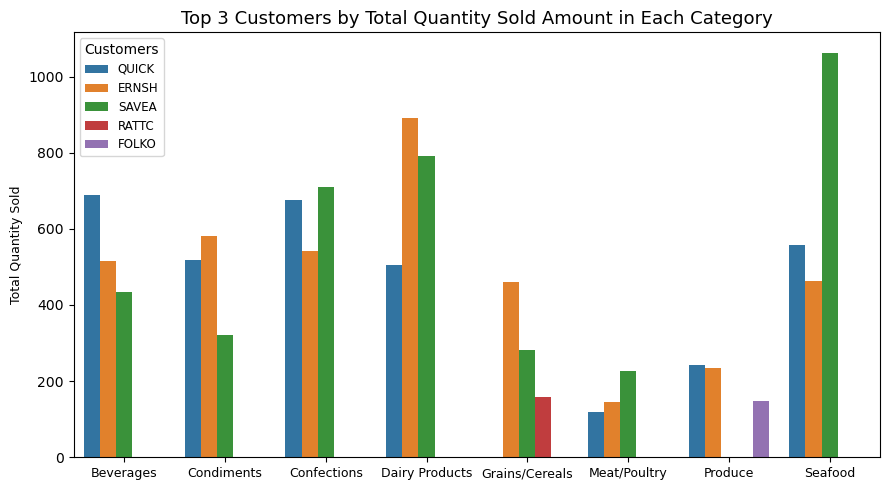

In [232]:
# Select customer_id, category names and total quantity sold
sales_data_2 = df11.groupby(['customer_id', 'category_name'])['total_quantity_sold'].sum().reset_index()

# Select the top 3 employees for each category
top_customers = sales_data_2.sort_values(['category_name', 'total_quantity_sold'], ascending=[True, False])\
                           .groupby('category_name')\
                           .head(3)

# Create multiple bar chart using categories and employees
plt.figure(figsize=(9, 5))

# Bar chart
sns.barplot(data=top_customers, x='category_name', y='total_quantity_sold', hue='customer_id', palette='tab10')

# Set title and labels
plt.title('Top 3 Customers by Total Quantity Sold Amount in Each Category', fontsize=13)
plt.xlabel('')
plt.ylabel('Total Quantity Sold', fontsize=9)
plt.xticks(size=9)

plt.tight_layout()
plt.legend(title='Customers', fontsize=8.5)
plt.show()


# CASE 5: SHIPPING ANALYSIS

We will examine the average shipping costs of the shipper companies, average shipping delivery times, and the total number of orders they carry.

In [88]:
sql9 = """select
	shipper_id,
	company_name,
	round(avg(freight)) as avg_shipping_cost,
	count(order_id) total_orders,
	round(avg(shipped_date - order_date)) as avg_delivery_day,
	round(avg(required_date - order_date)) as avg_required_day
from shippers s
join orders o on s.shipper_id = o.ship_via
group by 1,2
order by 1"""

In [89]:
df9 = sqlio.read_sql_query(sql9,conn)
df9

,shipper_id,company_name,avg_shipping_cost,total_orders,avg_delivery_day,avg_required_day
0,1,Speedy Express,65.0,249,9.0,28.0
1,2,United Package,87.0,326,9.0,28.0
2,3,Federal Shipping,80.0,255,7.0,28.0


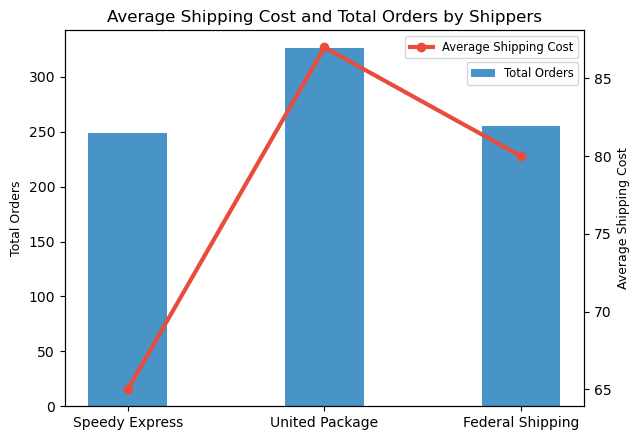

In [170]:
fig, ax1 = plt.subplots(figsize=(6.5, 4.5))

# First axis: Bar chart (total_orders)
sns.barplot(ax=ax1, x=df9['company_name'], y=df9['total_orders'], color='#3498db', label='Total Orders', width=0.4)
ax1.set_ylabel('Total Orders', fontsize=9)
ax1.set_xlabel('')
ax1.set_title('Average Shipping Cost and Total Orders by Shippers', fontsize=12)

# Create second axis
ax2 = ax1.twinx() 

# Second axis: Line chart (avg_shipping_cost)
ax2.plot(df9['company_name'], df9['avg_shipping_cost'], marker='o', color='#e74c3c', linewidth=3, label='Average Shipping Cost', linestyle='-')
ax2.set_ylabel('Average Shipping Cost', fontsize=9)

# Set legends
ax1.legend(loc='upper right',bbox_to_anchor=(1, 0.93), fontsize='small')
ax2.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


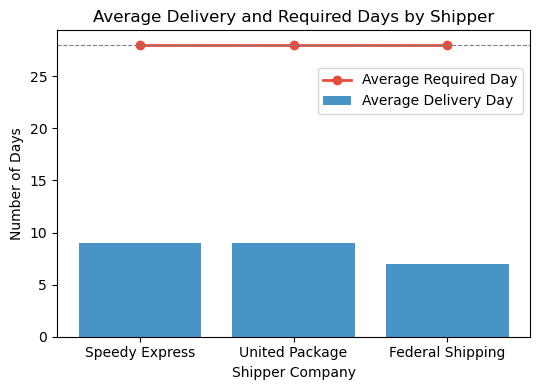

In [178]:
fig, ax1 = plt.subplots(figsize=(5.5,4))

# X-axis for bar chart
x = range(len(df9['company_name']))

# Bar chart (avg_delivery_day)
sns.barplot(x=df9['company_name'], y=df9['avg_delivery_day'], color='#3498db', label='Average Delivery Day')

# Line chart (avg_required_day)
plt.plot(df9['company_name'], df9['avg_required_day'], marker='o', color='#e74c3c', linewidth=2, label='Average Required Day', linestyle='-')

# Chart title and labels
plt.title('Average Delivery and Required Days by Shipper', fontsize=12)
plt.xlabel('Shipper Company', fontsize=10)
plt.ylabel('Number of Days', fontsize=10)
plt.axhline(y=28, color='grey', linestyle='--', linewidth=0.8)
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

plt.tight_layout()
plt.show()


# CASE 6: PRODUCT-CATEGORY ANALYSIS

In this analysis, we will examine the net profit that product categories bring to our company, as well as how many products are sold from each category. We will also consider the distribution of average shipping costs among categories.

In [155]:
sql10 = """WITH product_category AS(
	SELECT
	    c.category_name,
		description,
	    SUM(od.quantity) AS total_quantity_sold,
		ROUND(SUM(od.quantity * od.unit_price * (1 - od.discount))) AS total_net_revenue,
	    ROUND(SUM(o.freight)) AS total_shipping_cost,
	    ROUND(SUM(od.quantity * od.unit_price * od.discount)) AS total_discount_applied
	FROM orders o
	JOIN 
	    order_details od ON o.order_id = od.order_id
	JOIN 
	    products p ON od.product_id = p.product_id
	JOIN 
	    categories c ON p.category_id = c.category_id
	GROUP BY
		c.category_id, c.category_name
	)
	SELECT
		category_name,
		description,
	    total_quantity_sold,
		total_net_revenue,
	    total_shipping_cost,
	    total_discount_applied,
		total_net_revenue - total_shipping_cost as net_profit
	FROM product_category
	ORDER BY net_profit DESC;"""

In [156]:
df10 = sqlio.read_sql_query(sql10,conn)
df10

,category_name,description,total_quantity_sold,total_net_revenue,total_shipping_cost,total_discount_applied,net_profit
0,Beverages,"Soft drinks, coffees, teas, beers, and ales",9532,267868.0,39887.0,18659.0,227981.0
1,Dairy Products,Cheeses,9149,234507.0,38164.0,16823.0,196343.0
2,Meat/Poultry,Prepared meats,4199,163022.0,17769.0,15166.0,145253.0
3,Confections,"Desserts, candies, and sweet breads",7906,167357.0,32820.0,9742.0,134537.0
4,Seafood,Seaweed and fish,7681,131262.0,27723.0,10361.0,103539.0
5,Produce,Dried fruit and bean curd,2990,99985.0,13126.0,5284.0,86859.0
6,Condiments,"Sweet and savory sauces, relishes, spreads, an...",5298,106047.0,20067.0,7648.0,85980.0
7,Grains/Cereals,"Breads, crackers, pasta, and cereal",4562,95745.0,17750.0,4982.0,77995.0


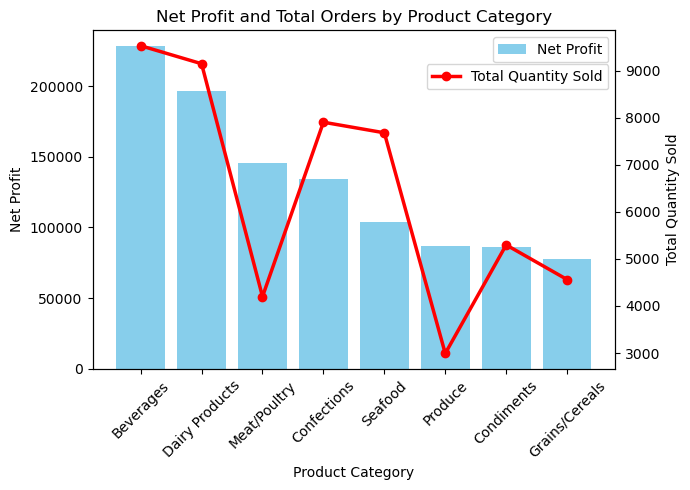

In [157]:
fig, ax1 = plt.subplots(figsize=(7, 5))

# Bar chart (net_profit)
bars = ax1.bar(df10['category_name'], df10['net_profit'], color='skyblue', label ='Net Profit')
ax1.set_xlabel('Product Category')
ax1.set_ylabel('Net Profit')
ax1.set_title('Net Profit and Total Orders by Product Category')
ax1.tick_params(axis='y')
ax1.set_xticklabels(df10['category_name'], rotation=45, size=10)

# Create second axis
ax2 = ax1.twinx()

# Line chart (total_quantity_sold)
line = ax2.plot(df10['category_name'], df10['total_quantity_sold'], color='red', marker='o', linewidth=2.5, label ='Total Quantity Sold')
ax2.set_ylabel('Total Quantity Sold')
ax2.tick_params(axis='y')

# Ad legend
ax1.legend(loc='upper right')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.92))

plt.tight_layout()
plt.show()
